<a href="https://colab.research.google.com/github/22b1074/Vehicle-Detection-IE-643-/blob/main/Rainy_Foggy_FEWSHOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision opencv-python matplotlib albumentations

In [ ]:
classes_of_interest = {
    'bicycle': 0,
    'motorcycle': 1,
    'car': 2,
    'truck': 3,
    'bus': 4
}

In [ ]:
import shutil
import os
source_path = '/content/drive/MyDrive/NormalWeather_IE643/val/labels'
destination_path = '/content/input_normal_noaug/val/labels'
os.makedirs(destination_path, exist_ok=True)
filenames = os.listdir(source_path)
for filename in filenames:
    if filename.endswith('.txt') and 'aug' not in filename:
        source_file = os.path.join(source_path, filename)
        destination_file = os.path.join(destination_path, filename)
        shutil.copy(source_file, destination_file)

In [ ]:
import shutil
source_path = '/content/drive/MyDrive/NormalWeather_IE643/val/images'
destination_path = '/content/input_normal_noaug/val/images'
os.makedirs(destination_path, exist_ok=True)
filenames = os.listdir(source_path)
for filename in filenames:
    if filename.endswith('.png') and 'aug' not in filename:
        source_file = os.path.join(source_path, filename)
        destination_file = os.path.join(destination_path, filename)
        shutil.copy(source_file, destination_file)

In [ ]:
# this is to check no.of classes in a particular dataset selected
import os

# label files
label_dir = '/content/input_normal_noaug/val/labels'  # change path as needed

class_counts = {label: 0 for label in classes_of_interest.keys()}
num_images = 0
# Iterate over all label files
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):  # Ensure it's a label file
        with open(os.path.join(label_dir, label_file), 'r') as f:
            num_images += 1
            lines = f.readlines()
            for line in lines:
                class_id = int(float(line.split()[0]))  # class id extraction  # class id extraction
                for class_name, id in classes_of_interest.items():
                    if class_id == id:
                        class_counts[class_name] += 1

# Print the number of images in each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} instances")
print(num_images)
total_instances = sum(class_counts.values())
num_classes = 5
#class_weights = {class_name: total_instances / (num_classes * count) for class_name, count in class_counts.items()}
#print(class_weights)
# use class weights when no class is set to zero in the dataset we are checking

bicycle: 1175 instances
motorcycle: 149 instances
car: 4667 instances
truck: 93 instances
bus: 98 instances
489


In [ ]:
# Here i am copying images with some conditions on no.of classes of vehicle classes for finding some balanced classes dataset and suitable test dataset to have similar no.of instances for val dataset and test dataset


import shutil
import numpy as np
labels_here_dir = '/content/input_normal_noaug/val/labels'
images_here_dir = '/content/input_normal_noaug/val/images'
target_images_dir = '/content/filtered_val_normal/images/ls12'
target_labels_dir = '/content/filtered_val_normal/labels/ls12'
os.makedirs(target_images_dir, exist_ok=True)
os.makedirs(target_labels_dir, exist_ok=True)
count_removed = 0
car_class_id = 2
bicycle_class_id = 0
motorcycle_class_id = 1
truck_class_id = 3
bus_class_id = 4
for label_file in os.listdir(labels_here_dir):
    labels_path = os.path.join(labels_here_dir, label_file)
    # Read the label file and check for the presence of cars
    with open(labels_path, 'r') as f:
        labels = f.readlines()

    # Count the number of car instances in the label file
    num_cars = sum(1 for label in labels if int(float(label.split()[0])) == car_class_id)
    num_bicycles = sum(1 for label in labels if int(float(label.split()[0])) == bicycle_class_id)
    num_buses = sum(1 for label in labels if int(float(label.split()[0])) == bus_class_id)
    num_trucks = sum(1 for label in labels if int(float(label.split()[0])) == truck_class_id)
    num_motorcycles = sum(1 for label in labels if int(float(label.split()[0])) == motorcycle_class_id)

    if num_motorcycles==1 and num_cars<3:
        #os.remove(labels_path)
        image_file = label_file.replace('.txt', '.png')
        image_path = os.path.join(images_here_dir, image_file)
        if os.path.exists(image_path):
            shutil.copy(image_path, target_images_dir)
            shutil.copy(labels_path, target_labels_dir)

            #os.remove(image_path)
            #os.remove(labels_path)
            count_removed += 1


# Print the count of removed/copied images and labels
print(f"Removed/Copied {count_removed} ")

Removed/Copied 5 


In [ ]:
!pip install keras tensorflow

In [ ]:
# For augmentations i used albumentations finally, at start used ImageDataGenerator but it didn't chaneg labels accordingly so used albumentations
import albumentations as A
from keras.preprocessing.image import img_to_array, load_img

# augmentation pipeline without brightness changes
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(-45,45), p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.Blur(blur_limit=3, p=0.2),
    A.GaussianBlur(p=0.2),  # Additional noise-related augmentations
    A.RandomGamma(p=0.3),    # Random gamma correction
    A.ElasticTransform(alpha=1.0, sigma=50, p=0.2),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.3),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2)  # Adaptive histogram equalization
],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)


In [ ]:
import cv2
def load_bboxes(label_file_path):
    bboxes = []
    class_labels = []
    with open(label_file_path, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            bboxes.append([x_center, y_center, width, height])  # YOLO format
            class_labels.append(int(class_id))  # Store the class id separately
    return bboxes, class_labels

def save_bboxes(output_label_path, bboxes, class_labels):
    with open(output_label_path, 'w') as file:
        for bbox, class_id in zip(bboxes, class_labels):
            x_center, y_center, width, height = bbox
            file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")
def augment_single_image(image_path, label_file_path, output_image_dir, output_label_dir, num_augments=5):
    # Load the image and bounding boxes
    image = cv2.imread(image_path)
    bboxes, class_labels = load_bboxes(label_file_path)

    # augmentations performed
    for i in range(num_augments):
        # Applied augmentations
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_class_labels = augmented['class_labels']

        # Naming augmented files with 'aug_{num}' to identify its augmented
        image_name = os.path.basename(image_path)
        output_image_path = os.path.join(output_image_dir, f"{image_name.replace('.png', f'_aug_{i}.png')}")
        output_label_path = os.path.join(output_label_dir, f"{image_name.replace('.png', f'_aug_{i}.txt')}")

        # augmented image
        cv2.imwrite(output_image_path, aug_image)

        # Save the corresponding labels with updated bounding boxes
        save_bboxes(output_label_path, aug_bboxes, aug_class_labels)

In [ ]:
image_path = '/content/filtered_val_normaltest/images/ls6cc/munster_000057_000019_foggy_beta_0.02.png'
label_file_path = '/content/filtered_val_normaltest/labels/ls6cc/munster_000057_000019_foggy_beta_0.02.txt'
output_image_dir = '/content/foggy_augs/val/images'
output_label_dir = '/content/foggy_augs/val/labels'
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)
augment_single_image(image_path, label_file_path, output_image_dir,output_label_dir, num_augments=15)

In [ ]:
import shutil
import os
destination_path = '/content/drive/MyDrive/foggy_fewshot_IE643/val/labels'
source_path = '/content/foggy_augs/val/labels'
os.makedirs(destination_path, exist_ok=True)
filenames = os.listdir(source_path)
for filename in filenames:
    if filename.endswith('.txt'):
        source_file = os.path.join(source_path, filename)
        destination_file = os.path.join(destination_path, filename)
        shutil.copy(source_file, destination_file)

In [ ]:
import shutil
import os
destination_path = '/content/drive/MyDrive/foggy_fewshot_IE643/val/images'
source_path = '/content/foggy_augs/val/images'
os.makedirs(destination_path, exist_ok=True)
filenames = os.listdir(source_path)
for filename in filenames:
    if filename.endswith('.png'):
        source_file = os.path.join(source_path, filename)
        destination_file = os.path.join(destination_path, filename)
        shutil.copy(source_file, destination_file)

In [ ]:
import random
import albumentations as A
import cv2
import os

# Define the rain augmentation function
rain_augment = A.Compose([
    A.RandomRain(
        brightness_coefficient=random.uniform(0.5, 0.8),  # Custom random value for brightness
        drop_length=random.randint(15, 20),                # Random drop length between 15 and 20
        drop_width=random.randint(1, 2),                   # Random drop width
        blur_value=random.randint(1, 3),                   # Random blur value for the rain
        p=1.0                                              # 100% chance of applying rain
    )
])

# Function to apply rain effect using Albumentations
def apply_rain_effect(image):
    # Apply the rain effect to the image using Albumentations
    augmented = rain_augment(image=image)
    return augmented['image']

# Function to process and save augmented images
def augment_with_rain(image_path, label_file_path, output_image_dir, output_label_dir):
    # Load the image
    image = cv2.imread(image_path)

    # Apply rain effect
    rain_image = apply_rain_effect(image)

    # Load the bounding boxes
    bboxes, class_labels = load_bboxes(label_file_path)

    # Check if output directories exist, if not, create them
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    # Save the augmented (rainy) image
    image_name = os.path.basename(image_path)
    output_image_path = os.path.join(output_image_dir, f"{image_name.replace('.png', '_rainy.png')}")
    cv2.imwrite(output_image_path, rain_image)

    # Save the corresponding labels
    output_label_path = os.path.join(output_label_dir, f"{image_name.replace('.png', '_rainy.txt')}")
    save_bboxes(output_label_path, bboxes, class_labels)

    print(f"Augmented image and label saved: {output_image_path}, {output_label_path}")

image_path1 = '/content/filtered_val_normal/images/ls12/frankfurt_000000_015389.png'  # Directory containing your images
label_file_path1 = '/content/filtered_val_normal/labels/ls12/frankfurt_000000_015389.txt'  # Directory containing your label files

# Set the output directories within Google Drive (modify these paths based on your Drive structure)
output_image_dir1 = '/content/drive/MyDrive/Rainy/val/images'
output_label_dir1 = '/content/drive/MyDrive/Rainy/val/labels'
augment_with_rain(image_path1,label_file_path1,output_image_dir1,output_label_dir1)

Augmented image and label saved: /content/drive/MyDrive/Rainy/val/images/frankfurt_000000_015389_rainy.png, /content/drive/MyDrive/Rainy/val/labels/frankfurt_000000_015389_rainy.txt


In [ ]:
image_path2 = '/content/drive/MyDrive/Rainy/val/images/frankfurt_000000_003920_rainy.png'
label_file_path2 = '/content/drive/MyDrive/Rainy/val/labels/frankfurt_000000_003920_rainy.txt'
output_image_dir2 = '/content/rainy_augs/val1/images'
output_label_dir2 = '/content/rainy_augs/val1/labels'
os.makedirs(output_image_dir2, exist_ok=True)
os.makedirs(output_label_dir2, exist_ok=True)
augment_single_image(image_path2, label_file_path2, output_image_dir2,output_label_dir2, num_augments=5)

In [ ]:
import shutil
import os
destination_path = '/content/drive/MyDrive/Rainy/val/labels'
source_path = '/content/rainy_augs/val1/labels'
os.makedirs(destination_path, exist_ok=True)
filenames = os.listdir(source_path)
for filename in filenames:
    if filename.endswith('.txt'):
        source_file = os.path.join(source_path, filename)
        destination_file = os.path.join(destination_path, filename)
        shutil.copy(source_file, destination_file)

In [ ]:
import shutil
import os
destination_path = '/content/drive/MyDrive/Rainy/val/images'
source_path = '/content/rainy_augs/val1/images'
os.makedirs(destination_path, exist_ok=True)
filenames = os.listdir(source_path)
for filename in filenames:
    if filename.endswith('.png'):
        source_file = os.path.join(source_path, filename)
        destination_file = os.path.join(destination_path, filename)
        shutil.copy(source_file, destination_file)

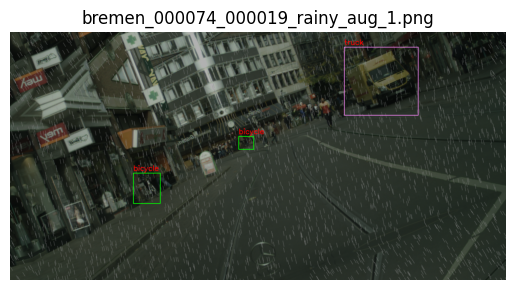

In [ ]:
# Visualization of IMages with Bounding boxes

import cv2
import matplotlib.pyplot as plt
classes_id_to_name = {
    0: 'bicycle',
    1: 'motorcycle',
    2: 'car',
    3: 'truck',
    4: 'bus'
}


def visualize_yolo_annotations(image_path, annotations_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    color_mapping = {
        0: (0, 255, 0),    # Green for bicycle
        1: (255, 0, 0),    # Blue for motorcycle
        2: (255, 0, 0),    # Red for car
        3: (238, 130, 238), # Violet for truck
        4: (255, 192, 203), # Pink for bus
    }

    # Check if the annotation file exists
    if os.path.isfile(annotations_path):
        # Read the annotations
        with open(annotations_path, 'r') as f:
            lines = f.readlines()

        # Process each annotation line
        for line in lines:
            # Split the line into components
            parts = line.strip().split()
            class_id = int(float(parts[0]))
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # the bounding box coordinates
            image_width = image.shape[1]
            image_height = image.shape[0]

            # Convert YOLO format to bounding box coordinates
            xmin = int((x_center - width / 2) * image_width)
            xmax = int((x_center + width / 2) * image_width)
            ymin = int((y_center - height / 2) * image_height)
            ymax = int((y_center + height / 2) * image_height)

            box_color = color_mapping.get(class_id, (255, 255, 255))  # Default to white if class_id is not found

            # Drawing the bounding box
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), box_color, 2)
            class_name = classes_id_to_name.get(class_id, "unkwown")
            cv2.putText(image, class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)

    # Display the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(os.path.basename(image_path))
    plt.show()

# usage
image_path = '/content/drive/MyDrive/Rainy/train/images/bremen_000074_000019_rainy_aug_1.png'  # image path
annotations_path = '/content/drive/MyDrive/Rainy/train/labels/bremen_000074_000019_rainy_aug_1.txt'  # corresponding annotations path of above image
visualize_yolo_annotations(image_path, annotations_path)